In [1]:
# Basic Libraries

import pandas as pd
import numpy as np

pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from tqdm import tqdm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Libraries for Classification and building Models

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, Dropout
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras.callbacks import ModelCheckpoint

In [4]:
# Project Specific Libraries

import os
import librosa
import librosa.display
# import glob 
import skimage

In [5]:
# Variables

dataset_path = '/content/drive/MyDrive/Colab Notebooks/SoundClassification/UrbanSounds8K'

In [6]:
df = pd.read_csv(f"{dataset_path}/UrbanSound8K.csv")

'''We will extract classes from this metadata.'''

df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


Text(0.5, 1.0, 'Linear-frequency power spectrogram')

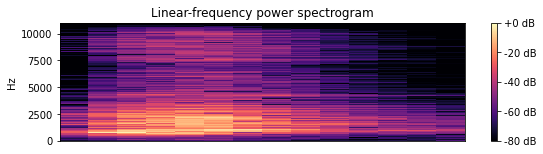

In [ ]:
dat1, sampling_rate1 = librosa.load(f'{dataset_path}/fold5/100032-3-0-0.wav')
dat2, sampling_rate2 = librosa.load(f'{dataset_path}/fold5/100263-2-0-117.wav')

plt.figure(figsize=(20, 10))
D = librosa.amplitude_to_db(np.abs(librosa.stft(dat1)), ref=np.max)
plt.subplot(4, 2, 1)
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')

Text(0.5, 1.0, 'Linear-frequency power spectrogram')

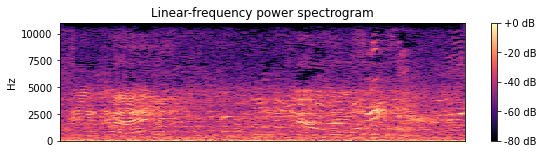

In [ ]:
plt.figure(figsize=(20, 10))
D = librosa.amplitude_to_db(np.abs(librosa.stft(dat2)), ref=np.max)
plt.subplot(4, 2, 1)
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')

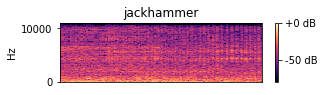

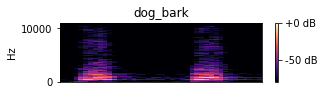

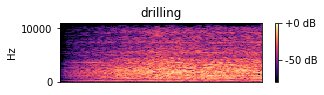

In [ ]:
'''Using random samples to observe difference in waveforms.'''

arr = np.array(df["slice_file_name"])
fold = np.array(df["fold"])
cla = np.array(df["class"])

for i in range(192, 197, 2):
    path = f'{dataset_path}/fold' + str(fold[i]) + '/' + arr[i]
    data, sampling_rate = librosa.load(path)
    plt.figure(figsize=(10, 5))
    D = librosa.amplitude_to_db(np.abs(librosa.stft(data)), ref=np.max)
    plt.subplot(4, 2, 1)
    librosa.display.specshow(D, y_axis='linear')
    plt.colorbar(format='%+2.0f dB')
    plt.title(cla[i])

In [ ]:
# Extracting features for single file

'''EXAMPLE'''

dat1, sampling_rate1 = librosa.load(f'{dataset_path}/fold5/100032-3-0-0.wav')
arr = librosa.feature.melspectrogram(y=dat1, sr=sampling_rate1)
arr.shape

(128, 14)

In [7]:
feature = []
label = []

def parser(row):
    # Function to load files and extract features
    for i in tqdm(range(8732)):
        file_name = f'{dataset_path}/fold' + str(df["fold"][i]) + '/' + df["slice_file_name"][i]
        # Here kaiser_fast is a technique used for faster extraction
        X, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        # extracting mfcc feature from data
        mels = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T,axis=0)        
        feature.append(mels)
        label.append(df["classID"][i])
    return [feature, label]
def single_parse(file_name):
    # Here kaiser_fast is a technique used for faster extraction
    X, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    # extracting mfcc feature from data
    mels = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T,axis=0) 
    return mels


In [ ]:
temp = parser(df)

  0%|          | 8/8732 [00:03<58:58,  2.47it/s]


KeyboardInterrupt: ignored

In [ ]:
# temp = np.array(temp)
# data = temp.transpose()
# np.save('/content/drive/MyDrive/Colab Notebooks/UrbanSounds8K/data.npy',data)

In [8]:
# Load Saved Numpy Array

data = np.load('/content/drive/MyDrive/Colab Notebooks/SoundClassification/UrbanSounds8K/data.npy',allow_pickle=True)


In [ ]:
# temp.shape
data.shape

(8732, 2)

In [9]:
X_ = data[:, 0]
Y = data[:, 1]
print(X_.shape, Y.shape)
X = np.empty([8732, 128])

(8732,) (8732,)


In [10]:
for i in range(8732):
    X[i] = (X_[i])
Y.shape

(8732,)

In [11]:
Y = to_categorical(Y)
Y.shape

(8732, 10)

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = 1)
X_train = X_train.reshape(6549, 16, 8, 1)
X_test = X_test.reshape(2183, 16, 8, 1)

In [ ]:
print(X_test[0].shape)
print(Y_test[0])

(16, 8, 1)
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


In [13]:
# CNN Model
input_dim = (16, 8, 1)
model = Sequential()
model.add(Conv2D(64, (3, 3), padding = "same", activation = "tanh", input_shape = input_dim))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), padding = "same", activation = "tanh"))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(1024, activation = "tanh"))
model.add(Dense(10, activation = "softmax"))

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [18]:
# To save the model

checkpoint_path = "/content/drive/MyDrive/Colab Notebooks/SoundClassification/UrbanSounds8K/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 8, 64)         640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 8, 4, 64)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 4, 128)         73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 2, 128)        0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 4, 2, 128)         0         
                                                                 
 flatten (Flatten)           (None, 1024)              0

In [ ]:



model.fit(X_train, Y_train, epochs = 100, batch_size = 50, validation_data = (X_test, Y_test),
          callbacks=[cp_callback]
          )

Epoch 1/100
130/131 [============================>.] - ETA: 0s - loss: 1.5622 - accuracy: 0.4671
Epoch 1: saving model to /content/drive/MyDrive/Colab Notebooks/UrbanSounds8K/cp.ckpt
131/131 [==============================] - 8s 55ms/step - loss: 1.5601 - accuracy: 0.4677 - val_loss: 1.3771 - val_accuracy: 0.5277
Epoch 2/100
131/131 [==============================] - ETA: 0s - loss: 1.1511 - accuracy: 0.6132
Epoch 2: saving model to /content/drive/MyDrive/Colab Notebooks/UrbanSounds8K/cp.ckpt
131/131 [==============================] - 7s 50ms/step - loss: 1.1511 - accuracy: 0.6132 - val_loss: 1.1714 - val_accuracy: 0.6060
Epoch 3/100
130/131 [============================>.] - ETA: 0s - loss: 1.0002 - accuracy: 0.6646
Epoch 3: saving model to /content/drive/MyDrive/Colab Notebooks/UrbanSounds8K/cp.ckpt
131/131 [==============================] - 8s 62ms/step - loss: 0.9990 - accuracy: 0.6644 - val_loss: 1.0632 - val_accuracy: 0.6661
Epoch 4/100
131/131 [==============================] - 

In [31]:

checkpoint_path = "/content/drive/MyDrive/Colab Notebooks/UrbanSounds8K/cp.ckpt"
# Loads the weights
model.load_weights(checkpoint_path)
expected = []
predicted = []
'''Prepairing data for generating confusion matrix.'''
for i in tqdm(range(4)):
        file_name = f'{dataset_path}/fold' + str(df["fold"][i]) + '/' + df["slice_file_name"][i]
        ft = single_parse(f'{dataset_path}/fold' + str(df["fold"][i]) + '/' + df["slice_file_name"][i])
        ft = ft.reshape(1,16, 8, 1)
        predictions = model.predict(ft)
        preds = np.argmax(predictions, axis = 1)
        predicted.append(preds[0])
        expected.append(df["classID"][i])




# Prdicting using test data
# predictions = model.predict(X_test)
# preds = np.argmax(predictions, axis = 1)
# print(preds)

# results = confusion_matrix(Tpreds)

100%|██████████| 4/4 [00:00<00:00,  4.78it/s]


In [32]:
# Example of a confusion matrix in Python
from sklearn.metrics import confusion_matrix
print("Expected:",expected)
print("Predicted:",predicted)
results = confusion_matrix(expected, predicted)
tn, fp, fn, tp = confusion_matrix(expected, predicted).ravel()
print('')
(tn,fp,fn,tp)

Expected: [3, 2, 2, 2]
Predicted: [3, 2, 2, 2]



(3, 0, 0, 1)

In [ ]:
# Predicting
ft = single_parse(f'{dataset_path}/fold5/100263-2-0-117.wav')
ft = ft.reshape(1,16, 8, 1)
predictions = model.predict(ft)
score = model.evaluate(X_test, Y_test)
print(score)

69/69 [==============================] - 2s 14ms/step - loss: 2.3114 - accuracy: 0.0618
[2.311439037322998, 0.06184150278568268]


In [ ]:
preds = np.argmax(predictions, axis = 1)
result = pd.DataFrame(preds)
print(preds)


# result.to_csv("UrbanSound8kResults.csv")

[2]


In [23]:

# Predicting
ft = single_parse(f'{dataset_path}/fold5/100263-2-0-117.wav')
ft = ft.reshape(1,16, 8, 1)
predictions = model.predict(ft)
preds = np.argmax(predictions, axis = 1)
result = pd.DataFrame(preds)
print(preds)

[2]
